In [1]:
import os
import sys
# block warnings from printing
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import collections
import xarray as xr
xr.set_options(keep_attrs=True)
import netCDF4 as nc
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import metpy.calc as mp
from metpy.units import units
from scipy.stats import ttest_ind, ttest_rel
from datetime import datetime

import cartopy
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cmocean.cm as cmo
import seaborn as sns

# settings
%config InlineBackend.figure_format = 'retina'

# add path to custom functions
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/py_functions")
from map_plot_tools import *
from colorbar_funcs import *
from data_funcs import *

In [2]:
### +++ FUNCTIONS +++ ###

## TIME-SERIES MEAN SEASONAL CLIMATOLOGIES ##
def season_mean(ds, calendar='standard'):
    seas_mean = ds.groupby('time.season').mean(dim='time') #sum(dim='time')
    return seas_mean

## ANNUAL SEASONAL MEAN CLIMATOLOGIES ##
def annual_season_mean(ds, calendar='standard'):
    ds_seasonal = {}
    ann_seasonal_mean = {}
    for season in ['DJF','MAM','JJA','SON']:
        # extract data for season
        ds_seasonal[season] = ds.where(ds['time.season'] == season)
        # I'm not sure what this step is doing
        if season == 'DJF':
            ds_seasonal[season] = ds_seasonal[season].shift(time=1)
        # get timeseries of seasonal mean climatologies
        ann_seasonal_mean[season] = ds_seasonal[season].groupby('time.year').mean(dim='time') #sum(dim='time')
        # but, cut first year of DJF timeseries as there is no Dec data from year -1
        if season == 'DJF':
            year_min = ann_seasonal_mean[season].year.min()+1
            year_max = ann_seasonal_mean[season].year.max()
            ann_seasonal_mean[season] = ann_seasonal_mean[season].sel(year=slice(year_min, year_max)) #.isel(year=slice(1,len(ann_seas_mean['DJF'].year)))
    return ann_seasonal_mean


## STATISTICAL SIGNIFICANCE TEST ##
# test with identical sample sizes
def sigtest(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_rel(yearmean1,yearmean2, axis=0)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals

# test with different sample sizes
def sigtest2n(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_ind(yearmean1,yearmean2, axis=0, equal_var = False)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals

def latitude_weighted_mean(var):
    """
    Calculate the mean of geospatial data taking into account unequal grid cell area
    """
    # get x and y coordinate data
    lons,lats = get_xy_coords(var)
    # determine weight based on latitude value
    weights = np.cos(np.deg2rad(lats))
    weights.name = 'weights'
    # calculate area-weighted values
    weighted_var = var.weighted(weights)
    # calculate global mean of weighted data
    weighted_mean = weighted_var.mean(dim=[lats.name,lons.name], keep_attrs=True)
    return(weighted_mean)


def longitude_flip(var):
    """ Convert longitude values from the -180:180 to 0:360 convention or vice versa.
        
        ** Only works for global data. Do not apply to data with a clipped longitude range **
        
        Parameters
        ----------
        var : Data Array
    """    
    # get var info
    x,_=get_xy_coords(var) # extract original longitude values
    lon_name=x.name        # store name of longitude coordinate
    nx=len(x)              # longitude resolution
    
    # determine longitude format and create an array of new lons in opposite convention
    if min(x)<0: 
        # if there are negative values, data is -180:180 and need to switch to 0:360
        new_lons=np.linspace((min(x)+180), (max(x)+180), nx)
    elif max(x)>180:
        # if the max value is >180, data is in 0:360 format and need to switch to -180:180
        new_lons=np.linspace((min(x)-180), (max(x)-180), nx)
        
    # shift the data by 180° of longitude
    nshift=nx//2
    var=var.roll({lon_name: nshift}, roll_coords=False)
            
    # update longitude coord with new values
    var=var.assign_coords({lon_name: new_lons})
    
    # add attributes documenting change
    timestamp=datetime.now().strftime("%B %d, %Y, %r")
    var.attrs['history']=f'flipped longitudes {timestamp}'
    var.attrs['original_lons']=x.values
    
    return(var)

def windSpd(u,v):
   windSpd=np.sqrt(u**2 + v**2)
   return windSpd

### AMIP Sims

In [4]:
### +++ DATA PATHS +++ ###

runNames=['merra2', 'PIctrl_E2.1_AMIP', 'cam.80p.amip', 'cam.sam.80p.amip', 'cam.85p.amip', 'cam.sam.85p.amip',
          'cam.1senvelope.amip', 'cam.sam.1senvelope.amip', 'cam.1.5senvelope.amip', 'cam.sam.1.5senvelope.amip']
keys=['obs', 'ctrl', 'ca80', 'ca+sa80', 'ca85', 'ca+sa85','ca1senv', 'ca+sa1senv', 'ca1.5senv', 'ca+sa1.5senv'] 
diags=['u_1000','v_1000'] # diagnostics

# store file paths in dictionary
dpath0='/discover/nobackup/projects/giss/baldwin_nip/dmkumar' # top level data directory
files={}

for i,key in enumerate(keys):
    files[key] = {}
    
    if key in ['obs']:
        files[key]['u_1000'] = f'{dpath0}/obs_data/merra2/merra2.U.1980-2022.monthly.nc'
        files[key]['v_1000'] = f'{dpath0}/obs_data/merra2/merra2.V.1980-2022.monthly.nc'
    
    elif key in ['ctrl', 'ca80', 'ca+sa80', 'ca85', 'ca+sa85','ca1senv', 'ca+sa1senv', 'ca1.5senv', 'ca+sa1.5senv']:
        run=runNames[i]
        for varn in diags:
            files[key][varn] = f'{dpath0}/{run}/timeseries/{varn}_timeseries.{run}.nc'
            

In [5]:
## ORGANIZE DATA AND CALCULATE CLIMATOLOGIES

latmin = -55
latmax = 30
lonmin = -150
lonmax = -30

# initialize dictionaries
amip_dat = {}
amip_time_mean = {}
amip_seas_mean = {}
amip_ann_seas_mean = {}

keys=['obs', 'ctrl', 'ca80', 'ca+sa80', 'ca85', 'ca+sa85','ca1senv', 'ca+sa1senv', 'ca1.5senv', 'ca+sa1.5senv'] 


print('Working on...')
for i,key in enumerate(keys):
    print(f'{key}')
    # initialize simulation sub-dicts
    amip_dat[key] = {}
    amip_time_mean[key] = {}
    amip_seas_mean[key] = {}
    amip_ann_seas_mean[key] = {}
    
    # open diag files
    for varn in ['u_1000','v_1000']:
        
        if key in ['obs']:
            if varn in ['u_1000']:
                ds = xr.open_dataset(files[key][varn], chunks={}).U[:,0,:,:].rename({'lev':'plm'})
                ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
                amip_dat[key][varn] = ds_clip
                del ds
                del ds_clip
            elif varn in ['v_1000']:
                ds = xr.open_dataset(files[key][varn], chunks={}).V[:,0,:,:].rename({'lev':'plm'})
                ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
                amip_dat[key][varn] = ds_clip
                del ds
                del ds_clip
                
        elif key in ['ctrl', 'ca80', 'ca+sa80', 'ca85', 'ca+sa85','ca1senv', 'ca+sa1senv', 'ca1.5senv', 'ca+sa1.5senv']:
            ds = xr.open_dataset(files[key][varn], chunks={})[varn]
            ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
            amip_dat[key][varn] = ds_clip
            del ds
            del ds_clip
                
        # calculate time-means
        amip_time_mean[key][varn] = amip_dat[key][varn].mean(dim='time')
        amip_seas_mean[key][varn] = season_mean(amip_dat[key][varn])
        amip_ann_seas_mean[key][varn] = annual_season_mean(amip_dat[key][varn])
    
    for varn in ['spd_1000']:
        amip_dat[key][varn]=windSpd(amip_dat[key]['u_1000'],amip_dat[key]['u_1000'])
        
        # calculate time-means
        amip_time_mean[key][varn] = amip_dat[key][varn].mean(dim='time')
        amip_seas_mean[key][varn] = season_mean(amip_dat[key][varn])
        amip_ann_seas_mean[key][varn] = annual_season_mean(amip_dat[key][varn])
    
print('Done.')

Working on...
obs
ctrl
ca80
ca+sa80
ca85
ca+sa85
ca1senv
ca+sa1senv
ca1.5senv
ca+sa1.5senv
Done.


In [6]:
## ++ CALCULATE SIGNIFICANCE OF MODEL RUN DIFFERENCES & MASK ++ ##

# initialize dictionaries
amip_diff = collections.defaultdict(dict)
amip_diff_mask = collections.defaultdict(dict)
amip_ptvals = collections.defaultdict(dict)

seasons = ['DJF','MAM','JJA','SON']
diags = ['u_1000', 'v_1000', 'spd_1000']

## COMPARING CONTROL MODEL RUNS WITH E2.1 MODIFIED TOPOGRAPHY RUNS
# For simulations/datasets with the same number of samples
print('Significance testing for...')
for key in ['ca80', 'ca+sa80', 'ca85', 'ca+sa85','ca1senv', 'ca+sa1senv', 'ca1.5senv', 'ca+sa1.5senv']:
    print(f'{key}')
    
    for varn in diags:
        # initialize simulation sub-dicts
        amip_diff[key][varn] = {}
        amip_diff_mask[key][varn] = {}
        amip_ptvals[key][varn] = {}
        # calculate significance
        for season in seasons:
            diff_, diff_mask_, ptvals_ = sigtest(amip_ann_seas_mean[key][varn][season], amip_ann_seas_mean['ctrl'][varn][season],
                                                 amip_seas_mean[key][varn].sel(season=season), amip_seas_mean['ctrl'][varn].sel(season=season))
            amip_diff[key][varn][season] = diff_
            amip_diff_mask[key][varn][season] = diff_mask_
            amip_ptvals[key][varn][season] = ptvals_
            
print('Done.')


Significance testing for...
ca80
ca+sa80
ca85
ca+sa85
ca1senv
ca+sa1senv
ca1.5senv
ca+sa1.5senv
Done.


In [7]:
## COMPARING CONTROL MODEL RUNS WITH OBS.
# need to re-grid obs data to E2.1 grid first
amip_regrid= {}
amip_seas_mean_regrid = {}
amip_ann_seas_mean_regrid = collections.defaultdict(dict)
lats=amip_time_mean['ctrl']['u_1000'].lat
lons=amip_time_mean['ctrl']['u_1000'].lon

diags = ['u_1000', 'v_1000', 'spd_1000']

for key in ['obs']:
    
    # initialize sub-dicts
    amip_regrid[key] = {}
    amip_seas_mean_regrid[key] = {}
    
    for varn in diags:
        # initialize simulation sub-dicts
        amip_diff[key][varn] = {}
        amip_diff_mask[key][varn] = {}
        amip_ptvals[key][varn] = {}
        amip_ann_seas_mean_regrid[key][varn] = {}
        
        # re-grid time mean obs
        amip_regrid[key][varn] = amip_time_mean[key][varn].interp(lat=lats, lon=lons, method='linear')
        # re-grid seasonal time-mean obs
        amip_seas_mean_regrid[key][varn] = amip_seas_mean[key][varn].interp(lat=lats, lon=lons, method='linear')
        
        # re-grid annual seasonal mean obs
        for season in seasons:
            amip_ann_seas_mean_regrid[key][varn][season] = amip_ann_seas_mean[key][varn][season].interp(lat=lats, lon=lons, method='linear')
            
            # calculate significance (not sure why sigtest2n requires adding the '.values' and sigtest function doesn't?)
            diff_, diff_mask_, ptvals_ = sigtest2n(amip_ann_seas_mean_regrid[key][varn][season], amip_ann_seas_mean['ctrl'][varn][season],
                                                   amip_seas_mean_regrid[key][varn].sel(season=season), amip_seas_mean['ctrl'][varn].sel(season=season))
            amip_diff[key][varn][season] = diff_
            amip_diff_mask[key][varn][season] = diff_mask_
            amip_ptvals[key][varn][season] = ptvals_

### Coupled Sims

In [8]:
### +++ DATA PATHS +++ ###

runNames=['merra2', 'E2pt1_PIctrl_restart', 'cam.1senv.cpld', 'cam.sam.1senv.cpld', 'maxtopo_E2pt1_PI_restart_new'] # E2.1 cpld simulations
keys=['obs', 'ctrl', 'cam-only', 'cam+sam', 'max-global'] # product key

# store file paths in dictionary
dpath0='/discover/nobackup/projects/giss/baldwin_nip/dmkumar' # top level data directory
files={}

for i,key in enumerate(keys):
    files[key] = {}
    
    if key in ['obs']:
        files[key]['u_1000'] = f'{dpath0}/obs_data/merra2/merra2.U.1980-2022.monthly.nc'
        files[key]['v_1000'] = f'{dpath0}/obs_data/merra2/merra2.V.1980-2022.monthly.nc'
    
    elif key in ['ctrl', 'cam-only', 'cam+sam', 'max-global']:
        run=runNames[i]
        for varn in diags:
            files[key][varn] = f'{dpath0}/{run}/timeseries/{varn}_timeseries.{run}.nc'
            

In [9]:
## ORGANIZE DATA AND CALCULATE CLIMATOLOGIES

# number of years to omit 
omit_yrs = 30
n_omit = omit_yrs * 12
tmax = 350 * 12
latmin = -55
latmax = 30
lonmin = -150
lonmax = -30

# initialize dictionaries
dat = {}
time_mean = {}
seas_mean = {}
ann_seas_mean = {}

print('Working on...')
for i,key in enumerate(keys):
    print(f'{key}')
    # initialize simulation sub-dicts
    dat[key] = {}
    time_mean[key] = {}
    seas_mean[key] = {}
    ann_seas_mean[key] = {}
    
    # open diag files
    for varn in ['u_1000','v_1000']:
        
        if key in ['obs']:
            if varn in ['u_1000']:
                ds = xr.open_dataset(files[key][varn], chunks={}).U[:,0,:,:].rename({'lev':'plm'})
                ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
                dat[key][varn] = ds_clip
                del ds
                del ds_clip
            elif varn in ['v_1000']:
                ds = xr.open_dataset(files[key][varn], chunks={}).V[:,0,:,:].rename({'lev':'plm'})
                ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
                dat[key][varn] = ds_clip
                del ds
                del ds_clip
                
        elif key in ['ctrl', 'cam-only', 'cam+sam', 'max-global']:
            ds = xr.open_dataset(files[key][varn], chunks={})[varn].isel(time=slice(n_omit,tmax))
            ds_clip = ds.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
            dat[key][varn] = ds_clip
            del ds
            del ds_clip
                
        # calculate time-means
        time_mean[key][varn] = dat[key][varn].mean(dim='time')
        seas_mean[key][varn] = season_mean(dat[key][varn])
        ann_seas_mean[key][varn] = annual_season_mean(dat[key][varn])
        
    for varn in ['spd_1000']:
        dat[key][varn]=windSpd(dat[key]['u_1000'],dat[key]['u_1000'])
        
        # calculate time-means
        time_mean[key][varn] = dat[key][varn].mean(dim='time')
        seas_mean[key][varn] = season_mean(dat[key][varn])
        ann_seas_mean[key][varn] = annual_season_mean(dat[key][varn])
    
print('Done.')

Working on...
obs
ctrl
cam-only
cam+sam
max-global
Done.


In [10]:
## ++ CALCULATE SIGNIFICANCE OF MODEL RUN DIFFERENCES & MASK ++ ##

# initialize dictionaries
diff = collections.defaultdict(dict)
diff_mask = collections.defaultdict(dict)
ptvals = collections.defaultdict(dict)

seasons = ['DJF','MAM','JJA','SON']
diags = ['u_1000', 'v_1000', 'spd_1000']

## COMPARING CONTROL MODEL RUNS WITH E2.1 MODIFIED TOPOGRAPHY RUNS
# For simulations/datasets with the same number of samples
print('Significance testing for...')
for key in ['cam-only', 'cam+sam', 'max-global']:
    print(f'{key}')
    
    for varn in diags:
        # initialize simulation sub-dicts
        diff[key][varn] = {}
        diff_mask[key][varn] = {}
        ptvals[key][varn] = {}
        # calculate significance
        for season in seasons:
            diff_, diff_mask_, ptvals_ = sigtest(ann_seas_mean[key][varn][season], ann_seas_mean['ctrl'][varn][season],
                                                 seas_mean[key][varn].sel(season=season), seas_mean['ctrl'][varn].sel(season=season))
            diff[key][varn][season] = diff_
            diff_mask[key][varn][season] = diff_mask_
            ptvals[key][varn][season] = ptvals_
            
print('Done.')


"""
## COMPARING CONTROL MODEL RUNS WITH OTHER SIMS
# For simulations/datasets with independent number of samples
for seas in seasons:
    diff['cesm_cam'][seas], diff_mask['cesm_cam'][seas], ptvals['cesm_cam'][seas] = sigtest2n(ann_seas_mean['cesm_cam'][seas].values, ann_seas_mean['cesm_ctrl'][seas].values,
                                                                                              seas_mean['cesm_cam'].sel(season=season).values, seas_mean['cesm_ctrl'].sel(season=season).values)
"""


Significance testing for...
cam-only
cam+sam
max-global
Done.


"\n## COMPARING CONTROL MODEL RUNS WITH OTHER SIMS\n# For simulations/datasets with independent number of samples\nfor seas in seasons:\n    diff['cesm_cam'][seas], diff_mask['cesm_cam'][seas], ptvals['cesm_cam'][seas] = sigtest2n(ann_seas_mean['cesm_cam'][seas].values, ann_seas_mean['cesm_ctrl'][seas].values,\n                                                                                              seas_mean['cesm_cam'].sel(season=season).values, seas_mean['cesm_ctrl'].sel(season=season).values)\n"

In [11]:
## COMPARING CONTROL MODEL RUNS WITH OBS.
# need to re-grid obs data to E2.1 grid first
regrid= {}
seas_mean_regrid = {}
ann_seas_mean_regrid = collections.defaultdict(dict)
lats=time_mean['ctrl']['u_1000'].lat
lons=time_mean['ctrl']['u_1000'].lon
diags = ['u_1000', 'v_1000', 'spd_1000']

for key in ['obs']:
    
    # initialize sub-dicts
    regrid[key] = {}
    seas_mean_regrid[key] = {}
    
    for varn in diags:
        # initialize simulation sub-dicts
        diff[key][varn] = {}
        diff_mask[key][varn] = {}
        ptvals[key][varn] = {}
        ann_seas_mean_regrid[key][varn] = {}
        
        # re-grid time mean obs
        regrid[key][varn] = time_mean[key][varn].interp(lat=lats, lon=lons, method='linear')
        # re-grid seasonal time-mean obs
        seas_mean_regrid[key][varn] = seas_mean[key][varn].interp(lat=lats, lon=lons, method='linear')
        
        # re-grid annual seasonal mean obs
        for season in seasons:
            ann_seas_mean_regrid[key][varn][season] = ann_seas_mean[key][varn][season].interp(lat=lats, lon=lons, method='linear')
            
            # calculate significance (not sure why sigtest2n requires adding the '.values' and sigtest function doesn't?)
            diff_, diff_mask_, ptvals_ = sigtest2n(ann_seas_mean_regrid[key][varn][season], ann_seas_mean['ctrl'][varn][season],
                                                   seas_mean_regrid[key][varn].sel(season=season), seas_mean['ctrl'][varn].sel(season=season))
            diff[key][varn][season] = diff_
            diff_mask[key][varn][season] = diff_mask_
            ptvals[key][varn][season] = ptvals_

In [12]:
## ++ CALCULATE DIFFERENCE OF CLIMATOLOGICAL FIELDS BETWEEN OBS & MODEL RUNS ++ ##

# initialize dictionaries
mdiff = {}
seas_mdiff = {}
diags = ['u_1000', 'v_1000', 'spd_1000']

print('Calculating field differences.')

for key in ['cam-only', 'cam+sam', 'max-global']: 
    
    # initialize key sub-dicts
    mdiff[key] = {}
    seas_mdiff[key] = {}
    
    for varn in diags:
        mdiff[key][varn] = time_mean[key][varn] - time_mean['ctrl'][varn]
        seas_mdiff[key][varn] = seas_mean[key][varn] - seas_mean['ctrl'][varn]
        
print('Done.')

Calculating field differences.
Done.


### Fig

In [13]:
### +++ TOPOGRAPHY CONTOURS +++ ###

# e2.1 topo bc info
land_mask=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').fgrnd
default=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').zatmo
cs1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam.sam.nc').zatmo
c1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam_only.nc').zatmo  
maxtopo=xr.open_dataset(f'{dpath0}/topo_files/giss.maxtopo.nc').zatmo  
# generate topo masks
c1env_mask=c1env.where((c1env-default)>0, 0)
cs1env_mask=cs1env.where((cs1env-default)>0, 0)
maxtopo_mask=maxtopo.where((maxtopo-default)>0, 0)

In [14]:
amip_usig = {}
amip_vsig = {}
#amip_wsig = {}

season = 'MAM'

for key in ['obs','ca80', 'ca+sa80', 'ca85', 'ca+sa85','ca1senv', 'ca+sa1senv', 'ca1.5senv', 'ca+sa1.5senv']:
    amip_usig[key] = np.where((amip_diff_mask[key]['u_1000'][season].mask==False) &
                              (amip_diff_mask[key]['v_1000'][season].mask==False),
                              amip_diff_mask[key]['u_1000'][season].data, np.nan)
    
    amip_vsig[key] = np.where((amip_diff_mask[key]['u_1000'][season].mask==False) &
                              (amip_diff_mask[key]['v_1000'][season].mask==False),
                              amip_diff_mask[key]['v_1000'][season].data, np.nan)
    """
    amip_wsig[key] = np.where((amip_diff_mask[key]['u_1000'][season].mask==False) &
                              (amip_diff_mask[key]['v_1000'][season].mask==False),
                              amip_diff_mask[key]['spd_1000'][season].data, np.nan)
    """

In [15]:
cpld_usig = {}
cpld_vsig = {}
#cpld_wsig = {}

season = 'MAM'

for key in ['obs','cam-only', 'cam+sam', 'max-global']:
    cpld_usig[key] = np.where((diff_mask[key]['u_1000'][season].mask==False) &
                              (diff_mask[key]['v_1000'][season].mask==False),
                              diff_mask[key]['u_1000'][season].data, np.nan)
    
    cpld_vsig[key] = np.where((diff_mask[key]['u_1000'][season].mask==False) &
                              (diff_mask[key]['v_1000'][season].mask==False),
                              diff_mask[key]['v_1000'][season].data, np.nan)
    """
    cpld_wsig[key] = np.where((diff_mask[key]['u_1000'][season].mask==False) &
                              (diff_mask[key]['v_1000'][season].mask==False),
                              diff_mask[key]['spd_1000'][season].data, np.nan)
    """

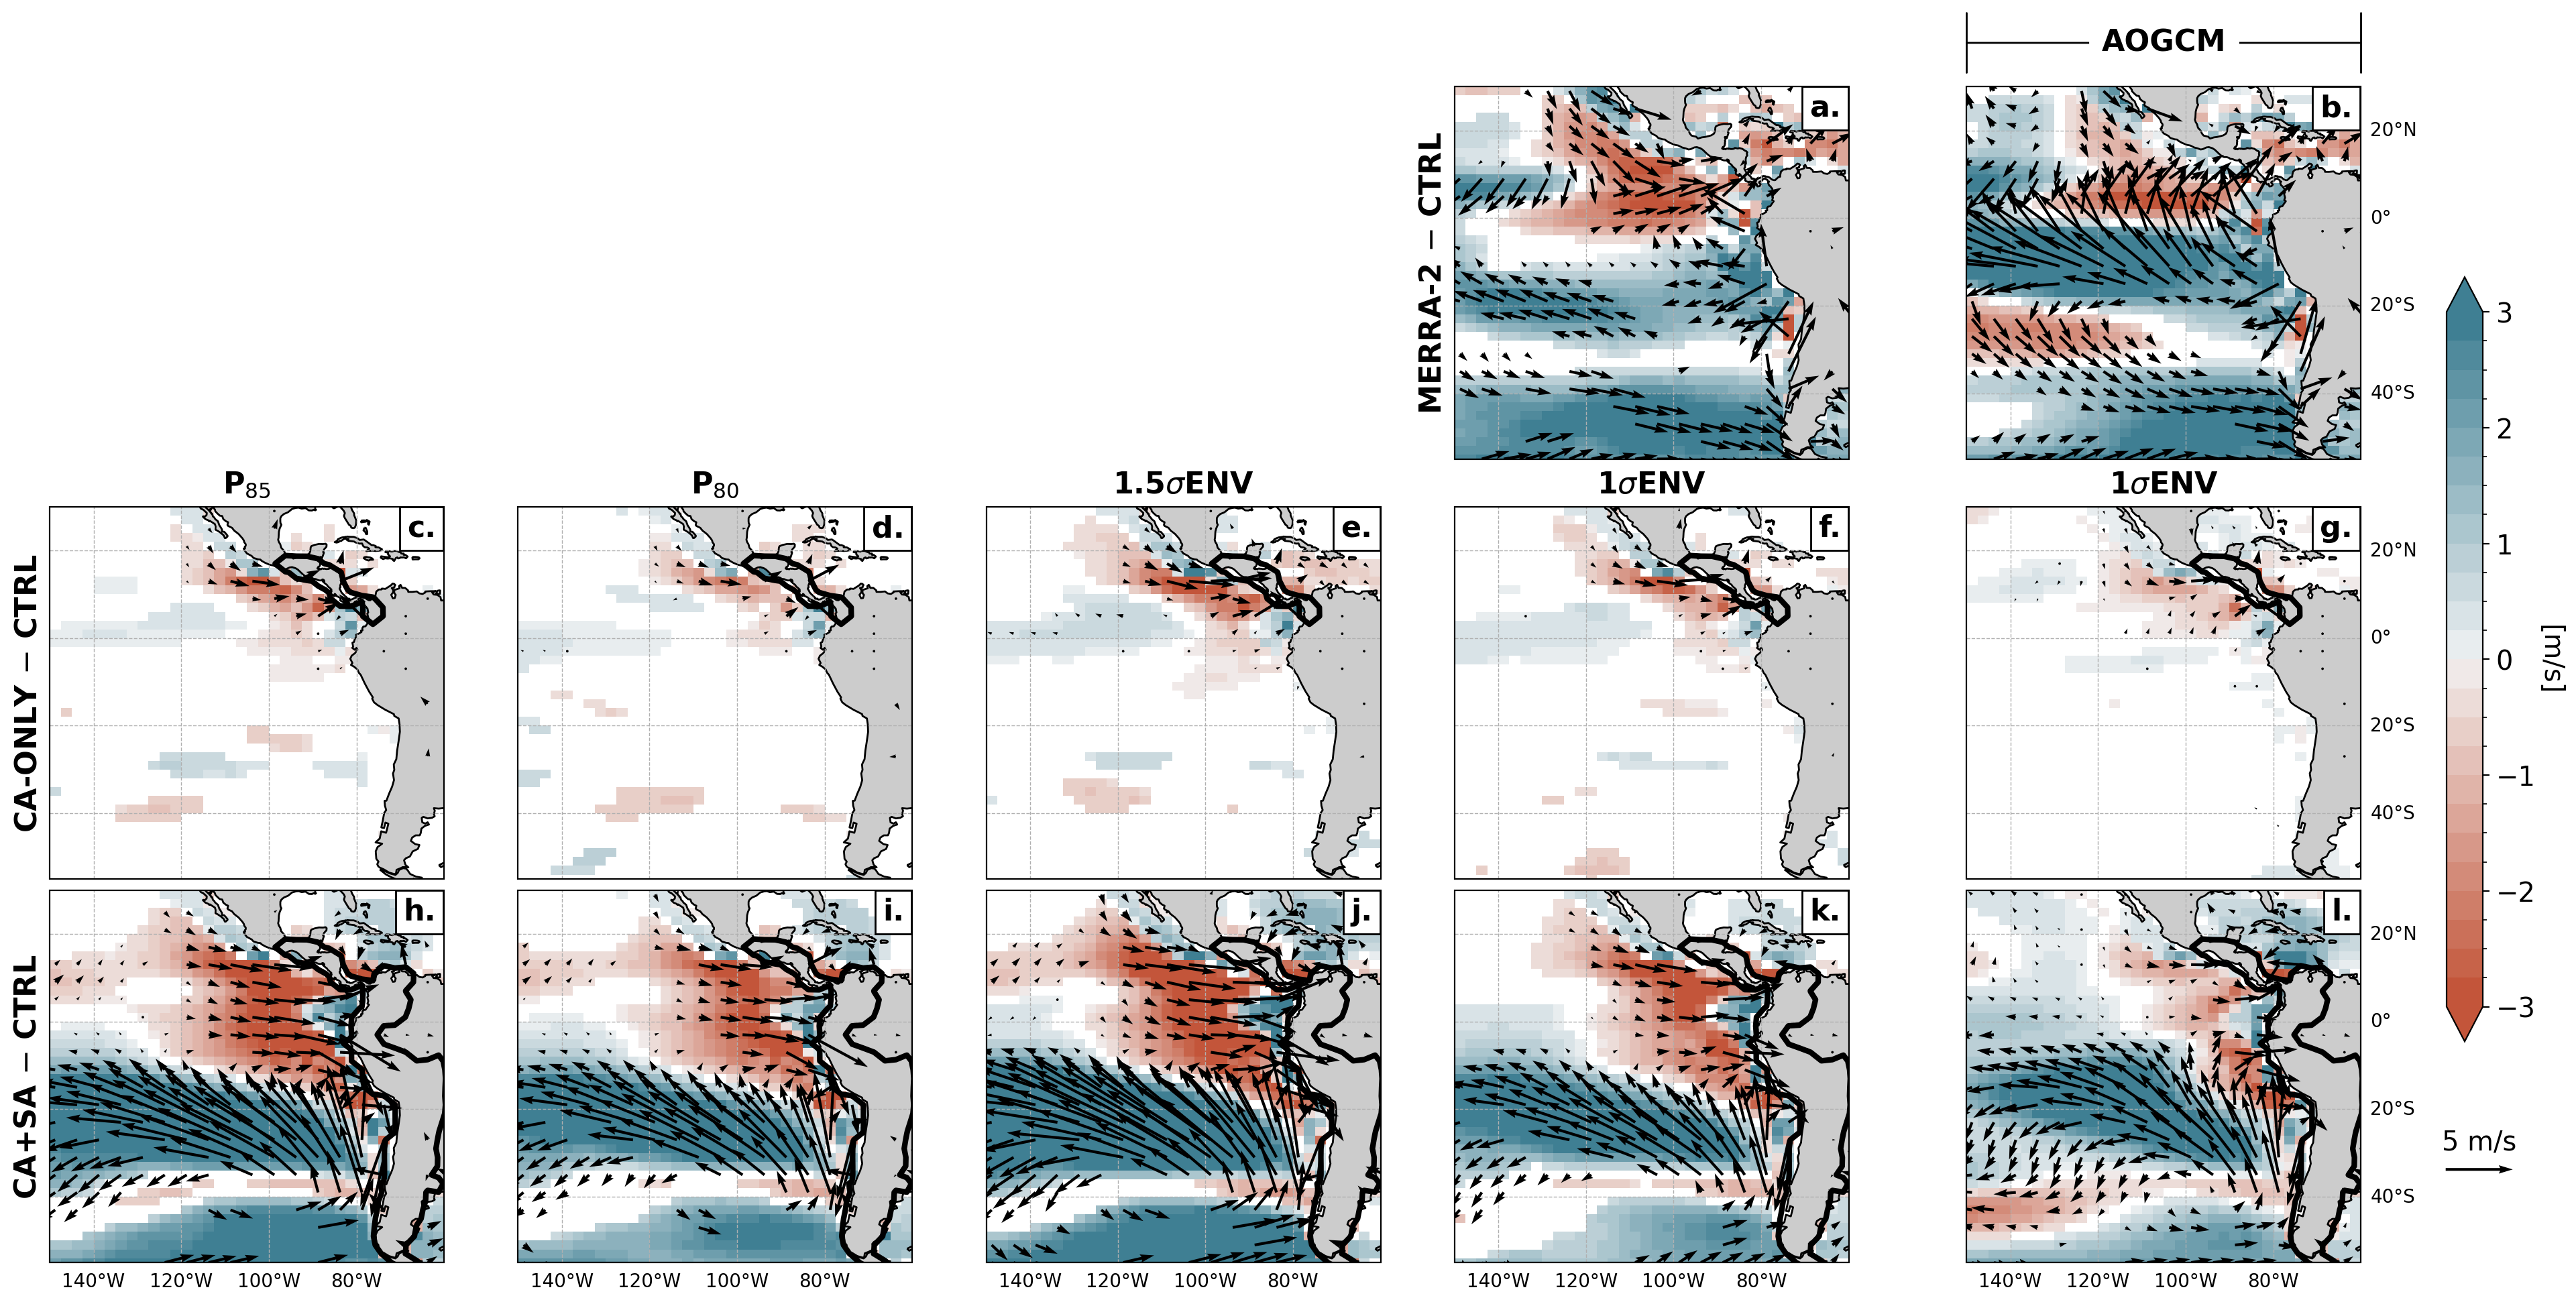

In [23]:
## Plot Model-Control Differences

# -------------------- #
#       Settings       #
# -------------------- #
season='MAM'
# plot specs
lw=1
text_kw={'color':  'k', 'weight': 'bold', 'size': 16, 'verticalalignment': 'center'}
titles=np.array(['P$_{85}$', 'P$_{80}$', '1.5$\sigma$ENV', '1$\sigma$ENV'])
arrow_kw={'arrowstyle':'|-|', 'color':'k', 'linewidth':1, 'shrinkA':0.05, 'shrinkB':0.05}
# vector specs
skip_n=2
w=0.0075
scalef=10
key_length=5
# colormap
#cmap,_,_,_=get_settings(field='wind', diff=True)
cmap = sns.diverging_palette(20, 220, as_cmap=True)
vmin=-3
vmax=3
levels=np.linspace(vmin, vmax, 25)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
# map specs
lat=dat['cam+sam']['u_1000'].lat
lon=dat['cam+sam']['u_1000'].lon
mlon = c1env_mask.lon
mlat = c1env_mask.lat
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds=[-150., -60., -55., 30.]

# ------------------- #
#      Make Plot      #
# ------------------- #
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(18,9.5), layout='constrained', subplot_kw={'projection':proj}) #

## OBS
ax[0,0].set_visible(False)
ax[0,1].set_visible(False)
ax[0,2].set_visible(False)

## Titles
#ax[0,3].annotate('', xy=(-60,40), xytext=(-1000,0), textcoords='offset points', label='_Hidden', arrowprops=arrow_kw, **text_kw)
#ax[0,3].text(-105, 40, 'AGCM', ha='center', backgroundcolor='white', **text_kw)

ax[0,4].annotate('', xy=(-60,40), xytext=(-150,40), label='_Hidden', arrowprops=arrow_kw, **text_kw)
ax[0,4].text(-105, 40, 'AOGCM', ha='center', backgroundcolor='white', **text_kw)

ax[0,3].text(-155, -12.5, 'MERRA-2 $-$ CTRL', rotation=90, ha='center', **text_kw)
ax[1,0].text(-155, -12.5, 'CA-ONLY $-$ CTRL', rotation=90, ha='center', **text_kw)
ax[2,0].text(-155, -12.5, 'CA+SA $-$ CTRL', rotation=90, ha='center', **text_kw)   


# MERRA-2 CLIMO
"""
ax[0,0].text(-170, -12.5, 'CLIMATOLOGY', rotation=90, ha='center', **text_kw)
vari=windSpd(obs.U_1000, obs.V_1000)
u_=obs.U_1000[mons].mean(dim='month')
v_=obs.V_1000[mons].mean(dim='month')
ax[0,0].pcolormesh(lon, lat, vari[mons].mean(dim='month'), cmap=cmap2, vmin=0, vmax=12, transform=trans)
q1=ax[0,0].quiver(lon[::skip_n], lat[::skip_n], u_[::skip_n,::skip_n], v_[::skip_n,::skip_n],
                     color='k', width=w, scale=20, scale_units='inches', units='height', transform=trans, zorder=100)
"""

# AGCM OBS
ax[0,3].pcolormesh(lon, lat, amip_diff_mask['obs']['spd_1000'][season], cmap=cmap, norm=norm, transform=trans)
q1=ax[0,3].quiver(lon[::skip_n], lat[::skip_n], amip_usig['obs'][::skip_n,::skip_n], amip_vsig['obs'][::skip_n,::skip_n],
                     color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)

# AOGCM OBS
ax[0,4].pcolormesh(lon, lat, diff_mask['obs']['spd_1000'][season], norm=norm, cmap=cmap, transform=trans)
q1=ax[0,4].quiver(lon[::skip_n], lat[::skip_n], cpld_usig['obs'][::skip_n,::skip_n], cpld_vsig['obs'][::skip_n,::skip_n],
             color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)


## AGCM
amip_keys=['ca85', 'ca80', 'ca1.5senv', 'ca1senv', 'ca+sa85', 'ca+sa80', 'ca+sa1.5senv', 'ca+sa1senv']
cols=[0,1,2,3,0,1,2,3]
for n,i in enumerate(amip_keys):
    coln=cols[n]
    # CAM-only
    if n in [0,1,2,3]:
        ax[1,coln].text(-105, 35, titles[n], rotation=0, ha='center', **text_kw)
        ax[1,coln].pcolormesh(lon, lat, amip_diff_mask[i]['spd_1000'][season], cmap=cmap, norm=norm, transform=trans)
        q1=ax[1,coln].quiver(lon[::skip_n], lat[::skip_n], amip_usig[i][::skip_n,::skip_n], amip_vsig[i][::skip_n,::skip_n],
                     color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)
        ax[1,coln].contour(mlon, mlat, c1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), zorder=100)
        
    # CAM+SAM 
    if n in [4,5,6,7]:
        ax[2,coln].pcolormesh(lon, lat, amip_diff_mask[i]['spd_1000'][season], cmap=cmap, norm=norm, transform=trans)
        q1=ax[2,coln].quiver(lon[::skip_n], lat[::skip_n], amip_usig[i][::skip_n,::skip_n], amip_vsig[i][::skip_n,::skip_n],
                             color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)
        ax[2,coln].contour(mlon, mlat, cs1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), zorder=100)
        ax[2,coln].text(-155, -12.5, ' ', rotation=90, ha='center', **text_kw)     

    

## AOGCM
# CAM-ONLY
ax[1,4].text(-165, -12.5, ' ', rotation=90, ha='center', **text_kw)
ax[1,4].text(-105, 35, titles[3], rotation=0, ha='center', **text_kw)
ax[1,4].pcolormesh(lon, lat, diff_mask['cam-only']['spd_1000'][season], norm=norm, cmap=cmap, transform=trans)
q1=ax[1,4].quiver(lon[::skip_n], lat[::skip_n], cpld_usig['cam-only'][::skip_n,::skip_n], cpld_vsig['cam-only'][::skip_n,::skip_n],
             color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)
ax[1,4].contour(mlon, mlat, c1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), zorder=100)

# CAM+SAM
cf=ax[2,4].pcolormesh(lon, lat, diff_mask['cam+sam']['spd_1000'][season], norm=norm, cmap=cmap, transform=trans)
q1=ax[2,4].quiver(lon[::skip_n], lat[::skip_n], cpld_usig['cam+sam'][::skip_n,::skip_n], cpld_vsig['cam+sam'][::skip_n,::skip_n],
             color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)
ax[2,4].contour(mlon, mlat, cs1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), zorder=100)
qk=ax[2,4].quiverkey(q1, 1.3, .25, key_length, rf'{key_length} m/s', labelcolor='k', labelpos='N', fontproperties={'size':'x-large'})

letters=['a.','a.','a.','a.','b.','c.','d.','e.','f.','g.','h.','i.','j.','k.','l.','m.','n.','o.','p.','q.','r.','s.']
for i, ax in enumerate(ax.flat): 
    ax.coastlines(color='k')
    ax.add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=1)
    ax.set_extent(map_bnds, crs=trans)
    letter=letters[i]
    ax.text(-61.85,28.3,letter, ha='right', va='top', **text_kw, zorder=100, bbox=dict(facecolor='white', edgecolor='black'))
    if i in [4,9]:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=False; gl.left_labels=False; gl.top_labels=False; gl.right_labels=True
    if i in [3,5,6,7,8]:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=False)
    if i in [10,11,12,13]:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    if i==14:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=True

        gl.xformatter=LONGITUDE_FORMATTER
        gl.yformatter=LATITUDE_FORMATTER
        gl.xlabel_style={'color': 'black', 'weight': 'normal', 'size':10}
        gl.ylabel_style={'color': 'black', 'weight': 'normal', 'size':10}
        gl.xlocator=mticker.FixedLocator([-140,-120, -100, -80, -60])
    
# add colorbar
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1.01, .2, 0.015, 0.6])
cbar=fig.colorbar(cf, ticks=[-3,-2,-1,0,1,2,3], orientation='vertical', extend='both', cax=cax)
cbar.set_label('[m/s]', labelpad=15, rotation=270, size='x-large', fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize='x-large')
#for tick in cbar.ax.yaxis.get_major_ticks():
#    tick.label2.set_fontweight('bold')

    
plt.savefig(f'1000hPa_winds.amip.cpld.mam.masked.pdf', transparent=True, bbox_inches='tight')

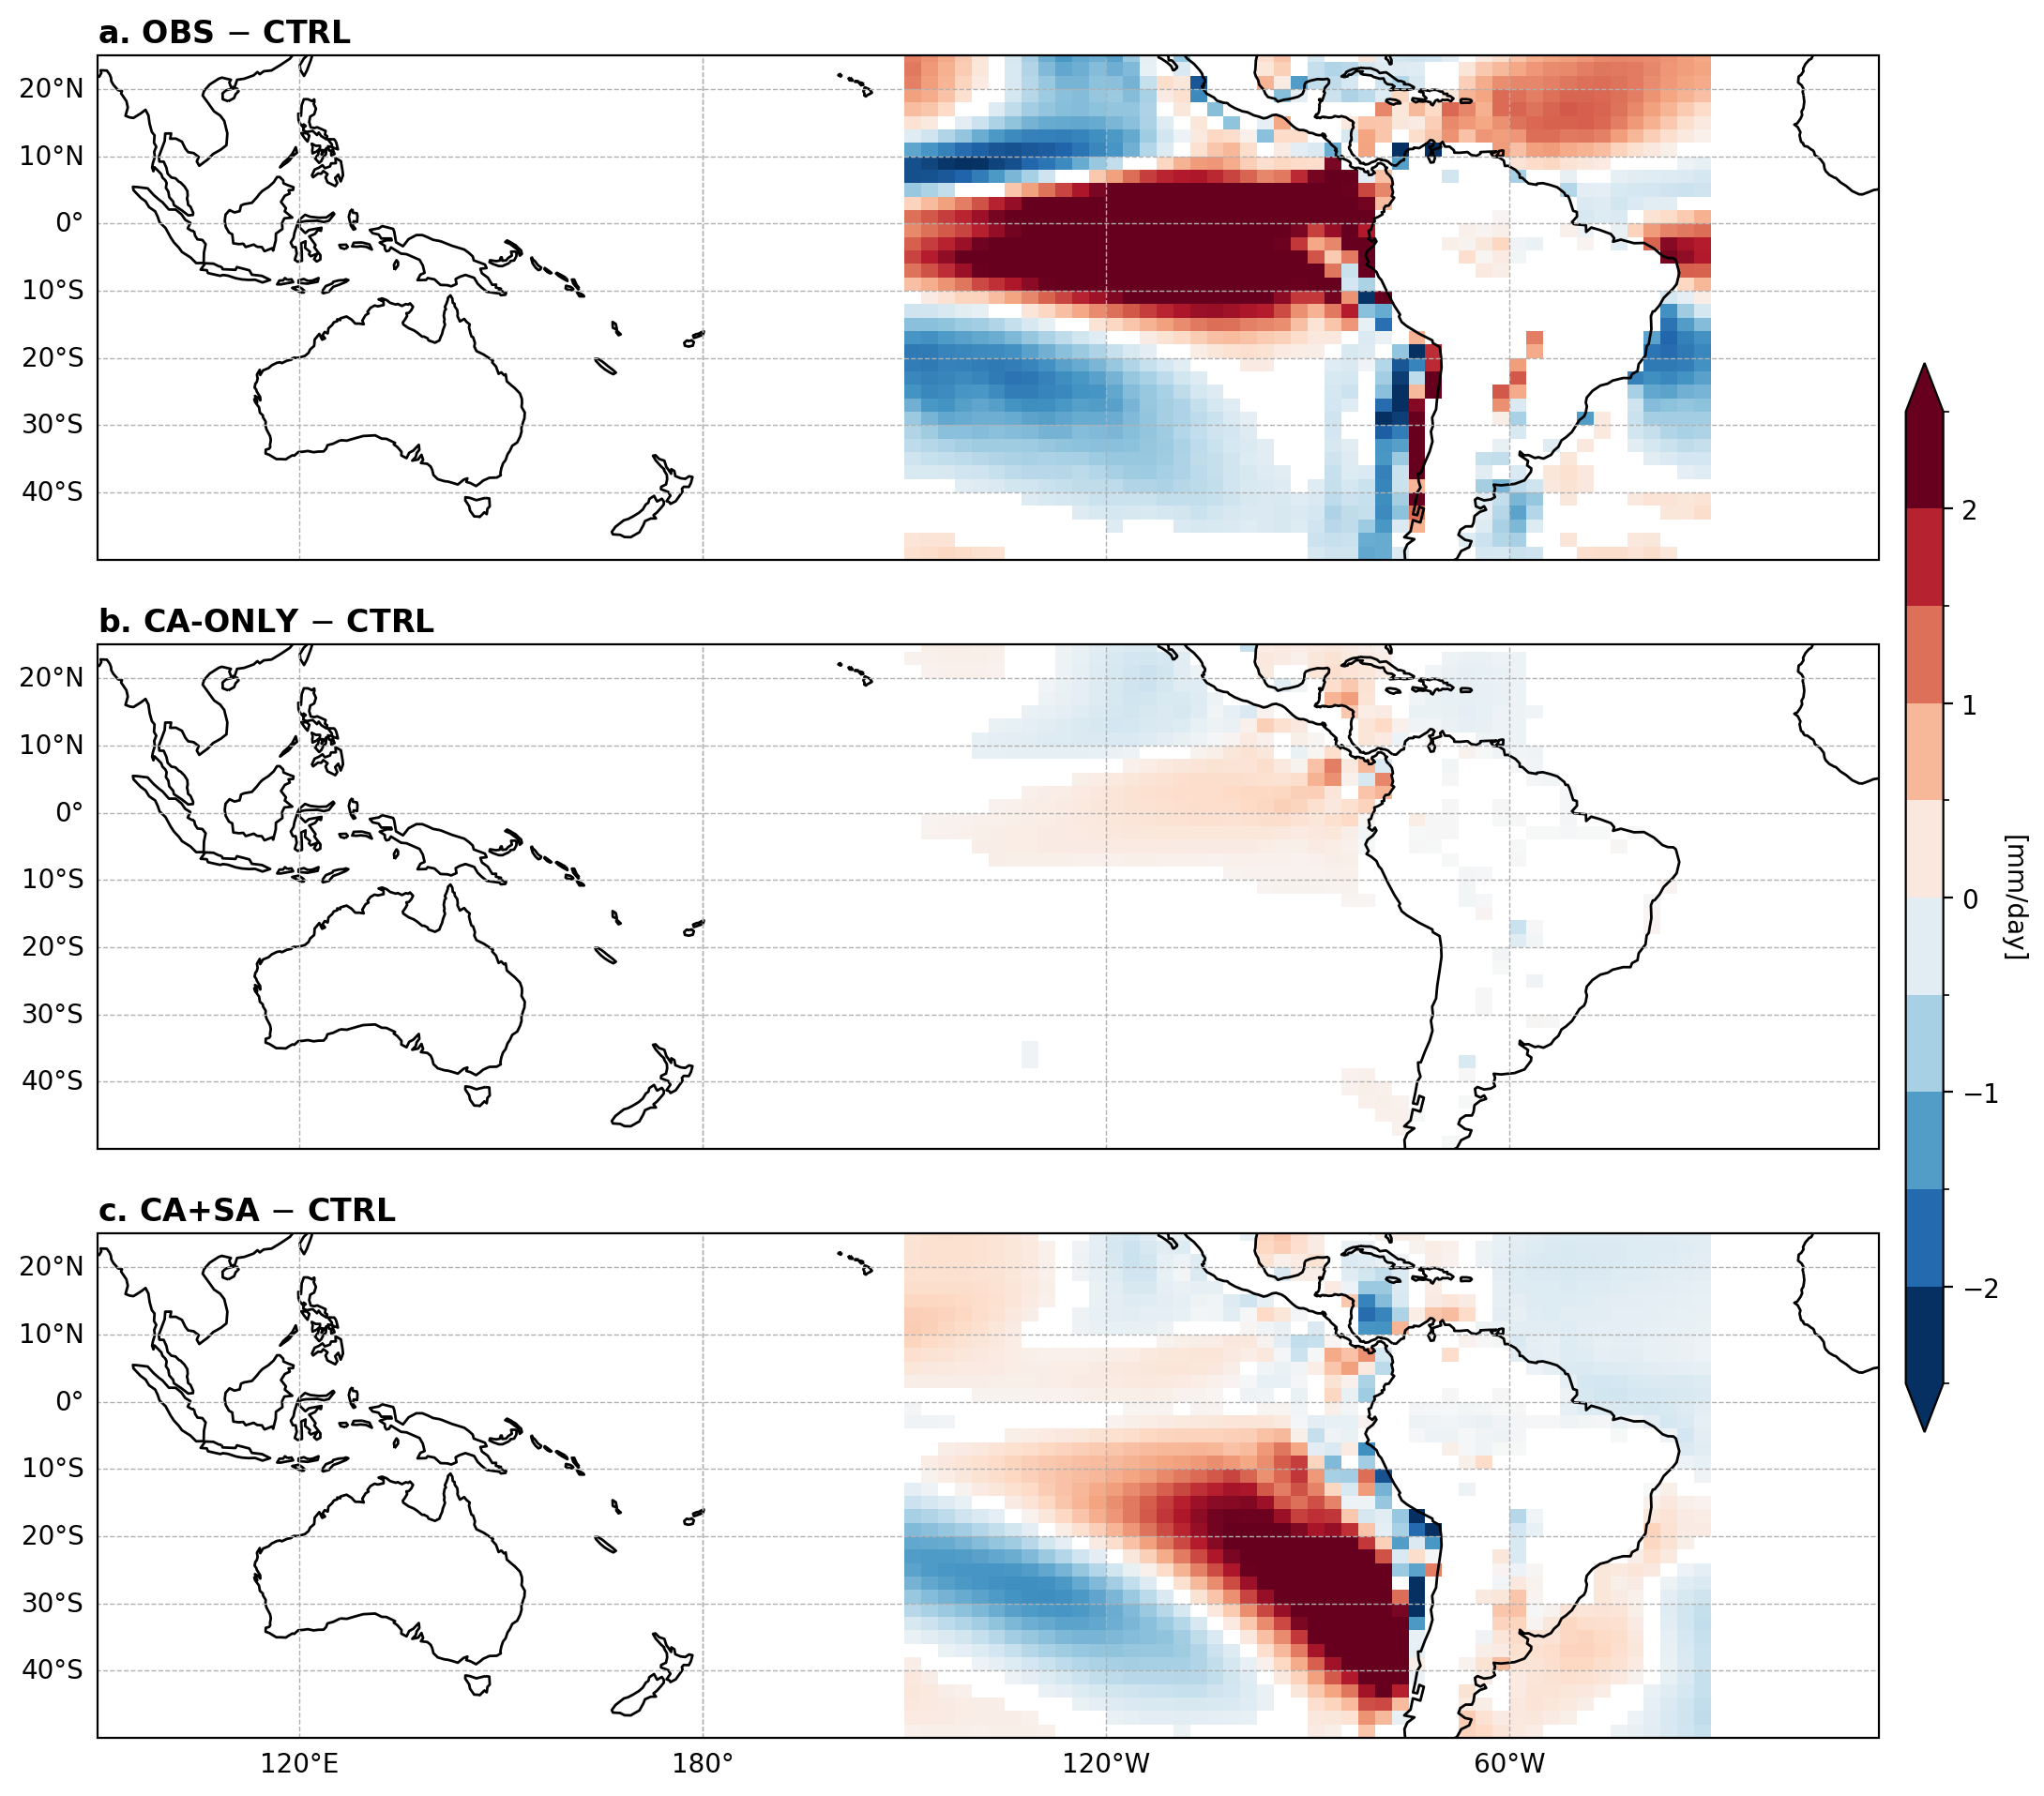

In [100]:
# -------------------- #
#       SETTINGS       #
# -------------------- #
# var info
varn = 'v_1000'
season = 'MAM'
# colormap spes
cmap=cm.RdBu_r
vmin=-2.5
vmax=2.5
levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
# text specs
text_kw={'weight': 'bold','ha': 'left','va': 'bottom','color': 'black'}
# map specs
proj=ccrs.PlateCarree(central_longitude=180)
trans=ccrs.PlateCarree()
bounds=[90,355,-50,25]


# -------------------- #
#          FIG         #
# -------------------- #
fig,ax=plt.subplots(nrows=3, ncols=1, figsize=(10, 9.5), layout='constrained', subplot_kw={'projection': proj})

# CTRL
ax[0].text(-90,26,'a. OBS $-$ CTRL', size=12, **text_kw)
ax[0].pcolormesh(lons, lats, diff_mask['obs'][varn][season], cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

# CA-ONLY
ax[1].text(-90,26,'b. CA-ONLY $-$ CTRL', size=12, **text_kw)
ax[1].pcolormesh(lons, lats, diff_mask['cam-only'][varn][season], cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
#ax[1].contour(lons, lats, c1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), transform=trans, zorder=10)

# CA+SA
ax[2].text(-90,26,'c. CA+SA $-$ CTRL', size=12, **text_kw)
ax[2].pcolormesh(lons, lats, diff_mask['cam+sam'][varn][season], cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
#ax[2].contour(lons, lats, cs1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), transform=trans, zorder=10)

letters=['a.','b.','c.']
for i, ax in enumerate(ax.flat):
    #ax.text(-88,-49,letters[i], size=14, **text_kw)
    """
    # add IMERG climatology contours
    cs=ax.contour(lons, lats, obs.precip[mons].mean(dim='month'), levels=plevels, linewidths=.75, colors='fuchsia', transform=trans, zorder=100)
    ax.clabel(cs, cs.levels, inline=True, inline_spacing=0, fontsize=8)
    """
    # map properties
    ax.coastlines(color='k')
    #ax.add_feature(cfeature.LAND, fc='silver', zorder=5)
    ax.set_extent(bounds, crs=trans)
    gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
    if i in [0,1]:
        gl.bottom_labels=False; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    if i==2:
        gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
        
# add colorbar
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1.01, 0.2, 0.02, 0.6])
cbar=fig.colorbar(cf, orientation='vertical', extend='both', cax=cax)
cbar.set_label('[m/s]', labelpad=10, rotation=270, size=10, fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize=10)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')
    
#plt.savefig(f'{opath}/winds.cpld.{season}.v2.pdf', transparent=True, bbox_inches='tight')